# Language

[TODO]

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [2]:
from pathlib import Path
import json
import pickle
from collections import Counter
import warnings

import tqdm 
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from icl.constants import DEVICE, DATA, ANALYSIS
from icl.language.model import get_model
from icl.language.utils import translate_int_to_str
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN
from icl.figures.plotting import WIDTH, HEIGHT, FULL_WIDTH, FULL_HEIGHT

warnings.filterwarnings('ignore')

model = get_model()
AWS_BUCKET_NAME = os.getenv("AWS_BUCKET_NAME")

Using pad_token, but it is not set yet.


# Figure 1

In [3]:
llc2_mean_df = pd.read_csv(ANALYSIS / 'language/L2W256-llc_1.csv')
llc2_std_df = pd.read_csv(ANALYSIS / 'language/L2W256-llc-std_1.csv')

llc2_mean_df = llc2_mean_df[['Step', 'L2W256-3M-LLC-rr - llc/mean']]
llc2_mean_df = llc2_mean_df.rename(columns={'L2W256-3M-LLC-rr - llc/mean': 'llc_mean'})
print(llc2_mean_df.head())

llc2_std_df = llc2_std_df[['Step', 'L2W256-3M-LLC-rr - llc/std']]
llc2_std_df = llc2_std_df.rename(columns={'L2W256-3M-LLC-rr - llc/std': 'llc_std'})
print(llc2_std_df.head())

steps = llc2_mean_df['Step'].values
losses = np.loadtxt(ANALYSIS / 'language/L2W256-losses.txt')
losses_df = pd.DataFrame({"Step": step, "loss": loss} for step, loss in zip(steps, losses))
print(losses_df.head())

   Step    llc_mean
0     0  123.559990
1   100  137.331192
2   200  143.640503
3   300  146.997894
4   400  148.288742
   Step    llc_std
0     0  50.648117
1   100  32.966717
2   200  30.679647
3   300  29.764782
4   400  29.250549
   Step      loss
0     0  8.966071
1   100  7.945969
2   200  7.749671
3   300  7.391308
4   400  7.253851


In [4]:
import numpy as np
from sklearn.decomposition import PCA
import pickle

with open(ANALYSIS / 'language/L2W256-per-token-logits.pkl', 'rb') as f:
    per_token_loss = pickle.load(f)

per_token_loss = np.array(per_token_loss)
print(per_token_loss.shape)

pca = PCA(n_components=3)
pca.fit(per_token_loss[:300])
projections = pca.transform(per_token_loss[:300])
pca.fit(per_token_loss)
projections = pca.transform(per_token_loss)
pca.explained_variance_ratio_

(501, 10000)


array([0.64620149, 0.08539305, 0.04737232])

In [5]:
from icl.figures.colors import gen_transition_colors

TRANSITIONS = [
    (0, 800, "LM1"),
    (800, 6500, "LM2"),
    (6500, 8500, "LM3"),
    (8500, 17_500, "LM4"),
    (17_500, 49_900, "LM5")
]

colors = gen_transition_colors(['A', 'A', 'B', 'A', 'Other']) # sns.color_palette("coolwarm_r", n_colors=len(TRANSITIONS))

In [6]:
with open(ANALYSIS / "language/lm_test_loss.pkl", "rb") as f:
    test_loss = pickle.load(f)

with open(ANALYSIS / 'language/norms.pkl', 'rb') as f:
    norms = pickle.load(f)

MODEL_ID = "LM1"

df = llc2_mean_df.merge(llc2_std_df, on='Step').merge(losses_df, on='Step')
# Rename column Steps to step
df = df.rename(columns={'Step': 'step'})
df['weight/norm'] = norms[:-1]
df['loss'] = test_loss[:-1]

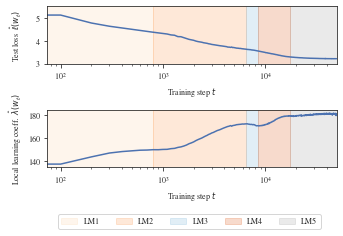

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from icl.constants import FIGURES

sns.set_palette('deep')

# Data setup (use your actual data here)
# For demonstration, replace evals_over_time_df with your DataFrame
# evals_over_time_df = ...

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(WIDTH * 1.5, HEIGHT * 1.5))

axs[0].set_ylabel(r'Test loss  $\hat{\ell}(w_t)$' '\n')
axs[1].set_ylabel(r'Local learning coeff.  $\hat\lambda(w_t)$')
# First line plot
sns.lineplot(df, x='step', y='loss', ax=axs[0])
# axs[0].set_title(r'(a) Loss over Time')
axs[0].set_xscale('log')
#axs[0].set_yscale('log')
# axs[0].set_xlim(100, 500_000)

# Second line plot
sns.lineplot(llc2_mean_df, x='Step', y='llc_mean', ax=axs[1])
# axs[1].set_title(r'(c) Local Learning Coefficient over Time')
axs[1].set_xscale('log')
# axs[1].set_xlim(100, 500_000)
 
# Set x-label for both plots
# for ax in axs:
axs[0].set_xlabel('')
axs[1].set_xlabel('Training step $t$')

axs[0].set_ylim(3, 5.5)
axs[1].set_ylim(135, 185)

handles = plot_transitions(axs, TRANSITIONS, xlim=True, colors=colors) 

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.55, 0.01), ncol=len(TRANSITIONS))


# axs[1].legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(TRANSITIONS))
# Layout adjustments
plt.tight_layout()
fig.set_facecolor('white')

fig.savefig(FIGURES / f"language/lm-fig1-top.pdf", bbox_inches='tight')
plt.show()


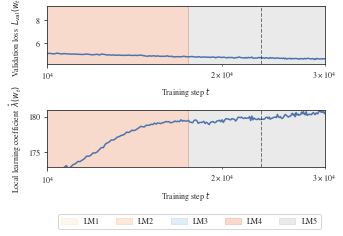

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from icl.constants import FIGURES

sns.set_palette('deep')

# Data setup (use your actual data here)
# For demonstration, replace evals_over_time_df with your DataFrame
# evals_over_time_df = ...

# Create figure
fig, axs = plt.subplots(2, 1, figsize=(WIDTH * 1.5, HEIGHT * 1.5))

# First line plot
# axs[0].set_title(r'(a) Loss over Time')
#axs[0].set_yscale('log')
# axs[0].set_xlim(100, 500_000)
axs[0].set_xscale('log')
axs[0].set_ylabel(r'Validation loss  $L_{\mathrm{val}}(w_t)$' '\n')
axs[0].set_xlabel('')
axs[1].set_xlabel('Training step $t$')
axs[1].set_ylim(173, 181)
axs[1].set_xscale('log')
axs[1].set_ylabel(r'Local learning coefficient  $\hat\lambda(w_t)$')


# Second line plot
sns.lineplot(losses_df, x='Step', y='loss', ax=axs[0])
sns.lineplot(llc2_mean_df, x='Step', y='llc_mean', ax=axs[1])
# axs[1].set_title(r'(c) Local Learning Coefficient over Time')
# axs[1].set_xlim(100, 500_000)
 
# Set x-label for both plots
# for ax in axs:

handles = plot_transitions(axs, TRANSITIONS, xlim=(100, 500_000), colors=colors) 

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.55, 0.01), ncol=len(TRANSITIONS))

for ax in axs:
    ax.set_xlim(10_000, 30_000)
    ax.axvline(23_300, color='black', linestyle='--', linewidth=1, alpha=0.5)


# axs[1].legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(TRANSITIONS))
# Layout adjustments
plt.tight_layout()
fig.set_facecolor('white')

fig.savefig(FIGURES / f"language/lm-fig1-top-zoom.pdf", bbox_inches='tight')
plt.show()


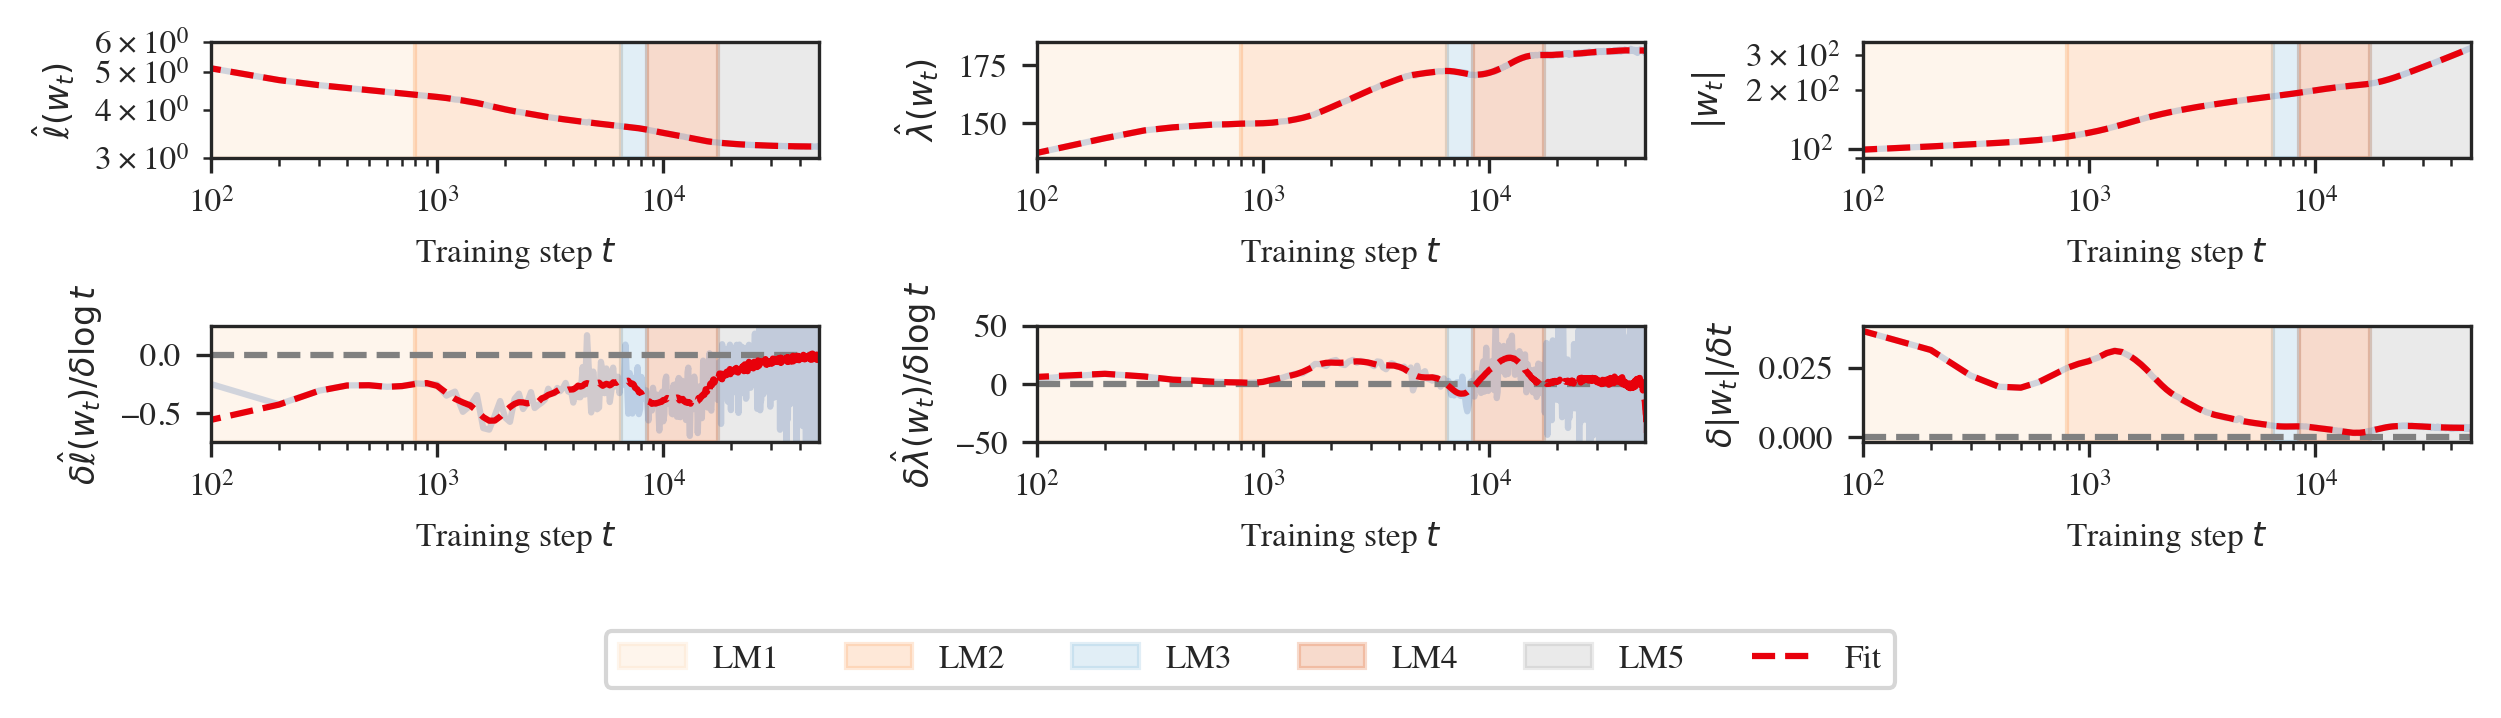

In [9]:
from matplotlib import lines as mlines
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from icl.figures.derivatives import d_dt

from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN

plt.rcParams['figure.dpi'] = 300

metrics_to_plot = [
    (r"\hat\ell(w_t)", "loss", {"logy": True, "derivative": "d_dlogt", "spline": True, "s": 0.1}, ),
    # (r"L_\mathcal{G}(t)", df["true/mse"], {"logy": False}),
    (r"\hat \lambda(w_t)", 'llc_mean', {"derivative": "d_dlogt", "spline": True}),
    (r"|w_t|", "weight/norm", {"derivative": "d_dt", "logy": True, "spline": True, "s": 0.1}),
] 
fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(FULL_WIDTH * 1.25, FULL_HEIGHT))

# axes = np.array(axes)
axes = axes.reshape(2, len(metrics_to_plot))

def str_dlog_dlogt(s):
    return r"$\delta \log " + s + r"/\delta\log t$"

for i, (metric_name, metric_key, kwargs) in enumerate(metrics_to_plot):
    use_spline = kwargs.get("spline", False)

    sns.lineplot(data=df, x="step", y=df[metric_key], ax=axes[0, i],label=metric_name, alpha=1 - use_spline * 0.75)
    # axes[0, i].plot(df['step'], metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(f"")
    axes[0, i].set_xlabel('Training step $t$')
    axes[0, i].set_ylabel(f"${metric_name}$")

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[0, i].legend().remove()

    slope_type = kwargs.get("derivative", "d_dlogt")

    if slope_type == "d_dlogt":
        slope_name = str_d_dlogt(metric_name)
        ys = d_dt(np.log(df['step'].values), df[metric_key].values)
    elif slope_type == "d_dt":
        slope_name = str_d_dt(metric_name)
        ys = d_dt(df['step'].values, df[metric_key].values)
    elif slope_type == "dlog_dlogt":
        slope_name = str_dlog_dlogt(metric_name)
        ys = d_dt(np.log(df['step'].values), np.log(df[metric_key].values))
    else:
        raise ValueError(f"Unknown slope type {slope_type}")

    sns.lineplot(data=df, x="step", y=ys, ax=axes[1, i], label=metric_name + " Slope", alpha=1 - use_spline * 0.75)
    axes[1, i].axhline(0, linestyle='--', color='gray')
    axes[1, i].set_title("")
    axes[1, i].set_xlabel('Step, $t$')
    axes[1, i].set_ylabel(slope_name)
    axes[1, i].legend().remove()
    
    if use_spline:     
        _steps = np.log(np.array(steps) + 1 ).reshape((-1, 1))
        _y = df.groupby('step').mean()[metric_key].values

        kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (5e-1, 1e3))

        # Create a Gaussian Process Regressor
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

        # Fit the Gaussian Process
        gp.fit(_steps, _y)
        _ypred = gp.predict(_steps)

        if slope_type == "d_dlogt":
            _derivy = d_dt(_steps, _ypred)
        elif slope_type == "d_dt":
            _derivy = d_dt(np.exp(_steps), _ypred)
        elif slope_type == "dlog_dlogt":            
            _derivy = d_dt(_steps, np.log(_ypred))
        
        axes[0, i].plot(steps, _ypred, label="Spline", linestyle='--', color=BRED)
        axes[1, i].plot(steps, _derivy, label="Spline", linestyle='--', color=BRED)



patch_list = plot_transitions(axes, TRANSITIONS, xlim=True, colors=colors)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(100, 49_000)
    # ax.set_ylabel("")

# axes[1, 1].set_yscale('symlog')
# axes[1, 0].set_yscale('symlog')
# axes[0,0].set_ylim(0, 70)

milestone_labels = [label for _, _, label in TRANSITIONS]
gp_fit_patch = mlines.Line2D([], [], color=BRED, linestyle='--', label="GP Fit")
fig.legend(patch_list + [gp_fit_patch], milestone_labels + ["Fit"], loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS) + 1)

fig.set_facecolor("white")
fig.tight_layout()


# axes[0, 1].set_ylim(0, 100)
# axes[1, 0].set_ylim(-2.25, 2.25)
# axes[1, 1].set_ylim(-150, 160)
axes[0, 0].set_ylim(3, 6)
axes[0, 1].set_ylim(135, 185)
axes[1, 0].set_ylim(-.75, .25)
axes[1, 1].set_ylim(-50, 50)

fig.savefig(FIGURES / f"language/{MODEL_ID}-loss-llc-with-slopes.pdf", bbox_inches='tight')